In [ ]:

!pip install timm medmnist torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import timm
import numpy as np
import random
from medmnist import PneumoniaMNIST
from torchmetrics.classification import Accuracy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
train_ds = PneumoniaMNIST(split="train", transform=train_tfms, download=True)
val_ds   = PneumoniaMNIST(split="val", transform=val_tfms, download=True)
test_ds  = PneumoniaMNIST(split="test", transform=val_tfms, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 4.17M/4.17M [00:07<00:00, 536kB/s]


In [ ]:
def get_model(model_name):
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=2
    )
    return model.to(device)


In [ ]:
MODELS = {
    "efficientnet_b4": "efficientnet_b4",
    "convnextv2": "convnextv2_tiny.fcmae",
}


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    acc = Accuracy(task="binary").to(device)

    for x, y in loader:
        x, y = x.to(device), y.squeeze().to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        acc.update(out.softmax(dim=1)[:,1], y)

    return total_loss / len(loader), acc.compute().item()


In [ ]:
@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    acc = Accuracy(task="binary").to(device)

    for x, y in loader:
        x, y = x.to(device), y.squeeze().to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        acc.update(out.softmax(dim=1)[:,1], y)

    return total_loss / len(loader), acc.compute().item()


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.best_loss = float("inf")
        self.counter = 0
        self.patience = patience

    def step(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


In [ ]:
def run_training(model_name, epochs, early_stop=False):
    model = get_model(model_name)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    stopper = EarlyStopping(patience=5)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)

        print(f"[{epoch+1}/{epochs}] "
              f"Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}")

        if early_stop and stopper.step(val_loss):
            print("⛔ Early stopping triggered")
            break

    return model, history


In [ ]:
# EfficientNet-B4 CNN 
effnet_model, effnet_hist = run_training(
    MODELS["efficientnet_b4"],
    epochs=30,
    early_stop=True
)

# ConvNeXt-V2 CNn
convnext_model, convnext_hist = run_training(
    MODELS["convnextv2"],
    epochs=30,
    early_stop=True
)


[1/30] Train Acc: 0.8681 | Val Acc: 0.8950
[2/30] Train Acc: 0.9242 | Val Acc: 0.8874
[3/30] Train Acc: 0.9450 | Val Acc: 0.9122
[4/30] Train Acc: 0.9531 | Val Acc: 0.9332
[5/30] Train Acc: 0.9569 | Val Acc: 0.9332
[6/30] Train Acc: 0.9650 | Val Acc: 0.9389
[7/30] Train Acc: 0.9658 | Val Acc: 0.9523
[8/30] Train Acc: 0.9705 | Val Acc: 0.9485
[9/30] Train Acc: 0.9771 | Val Acc: 0.9561
[10/30] Train Acc: 0.9783 | Val Acc: 0.9561
[11/30] Train Acc: 0.9805 | Val Acc: 0.9618
[12/30] Train Acc: 0.9845 | Val Acc: 0.9656
[13/30] Train Acc: 0.9839 | Val Acc: 0.9618
[14/30] Train Acc: 0.9843 | Val Acc: 0.9637
[15/30] Train Acc: 0.9930 | Val Acc: 0.9656
[16/30] Train Acc: 0.9926 | Val Acc: 0.9618
[17/30] Train Acc: 0.9932 | Val Acc: 0.9599
[18/30] Train Acc: 0.9921 | Val Acc: 0.9714
[19/30] Train Acc: 0.9911 | Val Acc: 0.9580
[20/30] Train Acc: 0.9962 | Val Acc: 0.9695
[21/30] Train Acc: 0.9945 | Val Acc: 0.9599
[22/30] Train Acc: 0.9955 | Val Acc: 0.9656
[23/30] Train Acc: 0.9951 | Val Acc: 0.96

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

[1/30] Train Acc: 0.7358 | Val Acc: 0.7424
[2/30] Train Acc: 0.8006 | Val Acc: 0.8721
[3/30] Train Acc: 0.9106 | Val Acc: 0.9160
[4/30] Train Acc: 0.9233 | Val Acc: 0.9237
[5/30] Train Acc: 0.9410 | Val Acc: 0.9313
[6/30] Train Acc: 0.9371 | Val Acc: 0.9485
[7/30] Train Acc: 0.9503 | Val Acc: 0.9580
[8/30] Train Acc: 0.9543 | Val Acc: 0.9542
[9/30] Train Acc: 0.9535 | Val Acc: 0.9561
[10/30] Train Acc: 0.9582 | Val Acc: 0.9618
[11/30] Train Acc: 0.9586 | Val Acc: 0.9122
[12/30] Train Acc: 0.9588 | Val Acc: 0.9637
[13/30] Train Acc: 0.9594 | Val Acc: 0.9618
[14/30] Train Acc: 0.9650 | Val Acc: 0.9676
[15/30] Train Acc: 0.9647 | Val Acc: 0.9714
[16/30] Train Acc: 0.9660 | Val Acc: 0.9714
[17/30] Train Acc: 0.9660 | Val Acc: 0.9656
[18/30] Train Acc: 0.9718 | Val Acc: 0.9676
[19/30] Train Acc: 0.9709 | Val Acc: 0.9790
[20/30] Train Acc: 0.9698 | Val Acc: 0.9752
[21/30] Train Acc: 0.9726 | Val Acc: 0.9847
[22/30] Train Acc: 0.9749 | Val Acc: 0.9580
[23/30] Train Acc: 0.9694 | Val Acc: 0.96

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


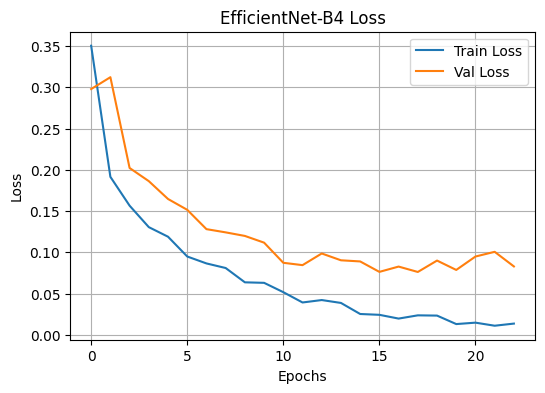

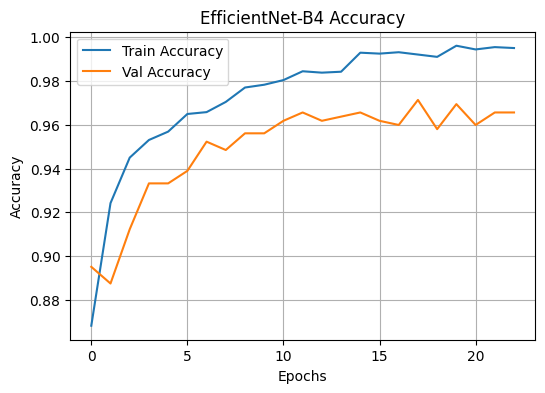

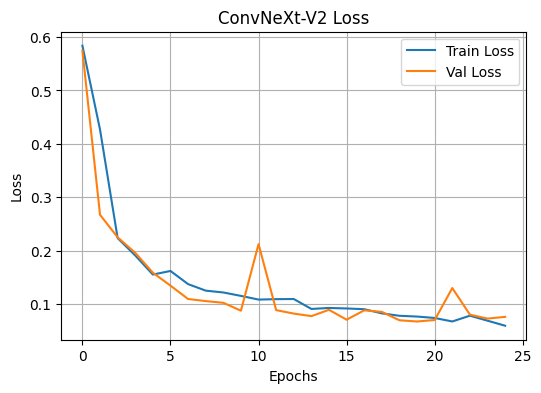

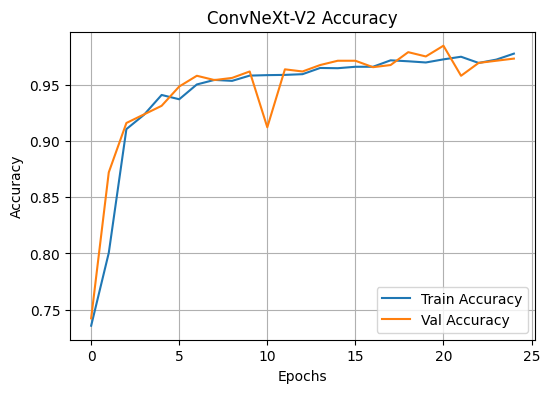

In [ ]:
plot_loss(effnet_hist, "EfficientNet-B4 Loss")
plot_accuracy(effnet_hist, "EfficientNet-B4 Accuracy")

plot_loss(convnext_hist, "ConvNeXt-V2 Loss")
plot_accuracy(convnext_hist, "ConvNeXt-V2 Accuracy")


In [ ]:
@torch.no_grad()
def get_test_probabilities(model, loader):
    model.eval()
    y_true, y_prob = [], []

    for x, y in loader:
        x = x.to(device)
        y = y.squeeze().cpu().numpy()

        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        y_true.extend(y)
        y_prob.extend(probs)

    return np.array(y_true), np.array(y_prob)


In [ ]:
from sklearn.metrics import f1_score

def evaluate_thresholds(y_true, y_prob):
    for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average="macro")
        print(f"Threshold {t:.1f} → Macro F1: {f1:.3f}")


In [ ]:
y_true, y_prob = get_test_probabilities(effnet_model, test_loader)
evaluate_thresholds(y_true, y_prob)


Threshold 0.3 → Macro F1: 0.846
Threshold 0.4 → Macro F1: 0.861
Threshold 0.5 → Macro F1: 0.869
Threshold 0.6 → Macro F1: 0.875
Threshold 0.7 → Macro F1: 0.885


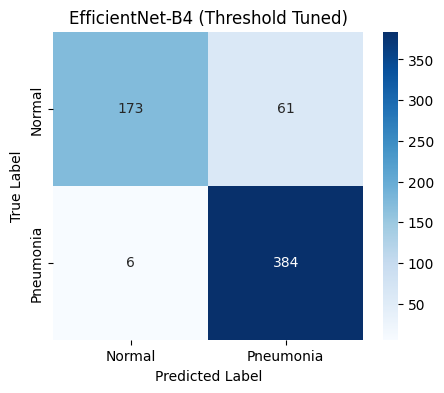

              precision    recall  f1-score   support

      Normal       0.97      0.74      0.84       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



In [ ]:
best_threshold = 0.65
y_pred = (y_prob >= best_threshold).astype(int)

plot_confusion_matrix(
    y_true, y_pred,
    "EfficientNet-B4 (Threshold Tuned)"
)

print_classification_report(y_true, y_pred)


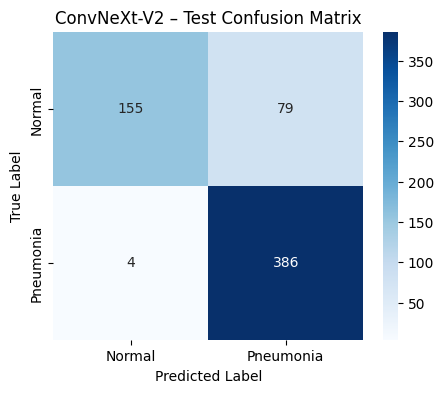

              precision    recall  f1-score   support

      Normal       0.97      0.66      0.79       234
   Pneumonia       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [ ]:
y_true_cnx, y_pred_cnx = get_test_predictions(convnext_model, test_loader)

plot_confusion_matrix(
    y_true_cnx,
    y_pred_cnx,
    "ConvNeXt-V2 – Test Confusion Matrix"
)

print_classification_report(y_true_cnx, y_pred_cnx)
